In [3]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.optim.lr_scheduler import StepLR

In [18]:
import torch
import torch.nn as nn

class Multiscale1DFitter(nn.Module):
    def __init__(self, function, x_data, input_channels, num_params, scaler=None, 
                 post_processing=None, device="cuda", loops_scaler=None, **kwargs):
        super().__init__()

        self.input_channels = input_channels
        self.scaler = scaler
        self.function = function
        self.x_data = x_data
        self.post_processing = post_processing
        self.device = device
        self.num_params = num_params
        self.loops_scaler = loops_scaler

        # Input block of 1d convolution
        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.input_channels, out_channels=8, kernel_size=1),  # Adjusted kernel size
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=1),  # Adjusted kernel size
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=1),  # Adjusted kernel size
            nn.SELU(),
            nn.AdaptiveAvgPool1d(64)
        )

        # Fully connected block
        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.SELU(),
            nn.Linear(32, 20),
            nn.SELU(),
        )

        # 2nd block of 1d-conv layers
        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=1),  # Adjusted kernel size
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1),  # Adjusted kernel size
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1),  # Adjusted kernel size
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1),  # Adjusted kernel size
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1),  # Adjusted kernel size
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=1),  # Adjusted kernel size
            nn.SELU(),
            nn.AdaptiveAvgPool1d(16),  # Adaptive pooling layer
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=1),  # Adjusted kernel size
            nn.SELU(),
            nn.AdaptiveAvgPool1d(8),  # Adaptive pooling layer
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=1),  # Adjusted kernel size
            nn.SELU(),
            nn.AdaptiveAvgPool1d(4),  # Adaptive pooling layer
        )

        # Flatten layer
        self.flatten_layer = nn.Flatten()

        # Final embedding block - Output num_params values - linear
        self.hidden_embedding = nn.Sequential(
            nn.Linear(28, 16),
            nn.SELU(),
            nn.Linear(16, 8),
            nn.SELU(),
            nn.Linear(8, self.num_params),
        )

    def forward(self, x, n=-1):
        # Ensure input x is in the correct shape (batch_size, channels, sequence_length)
        x = x.unsqueeze(1)  # Add channel dimension
        
        # Pass through 1st block of convolutions and pooling
        x1 = self.hidden_x1(x)
        x1_flat = self.flatten_layer(x1)

        # Pass through fully connected layers
        xfc = self.hidden_xfc(x1_flat)

        # Reshape for 2nd block of convolutions
        x2 = torch.swapaxes(x, 1, 2)  # Swap channels and sequence_length
        x2 = self.hidden_x2(x2)
        x2_flat = self.flatten_layer(x2)

        # Concatenate features from both blocks
        encoded = torch.cat((xfc, x2_flat), 1)

        # Pass through final embedding layers
        embedding = self.hidden_embedding(encoded)

        # Scale parameters if scaler is provided
        if self.scaler is not None:
            embedding = embedding * torch.tensor(self.scaler.scale_).to(self.device) + torch.tensor(self.scaler.mean_).to(self.device)

        # Call external fitting function
        fits = self.function(embedding, self.x_data, device=self.device)
        out = fits

        # Perform post-processing if required
        if self.post_processing is not None:
            out = self.post_processing.compute(fits)

        # Scale outputs using loops_scaler if provided
        if self.loops_scaler is not None:
            out_scaled = (out - torch.tensor(self.loops_scaler.mean).to(self.device)) / torch.tensor(self.loops_scaler.std).to(self.device)
        else:
            out_scaled = out

        # Return outputs based on training mode
        if self.training:
            return out_scaled, embedding
        else:
            return out_scaled, embedding, fits

In [3]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [22]:
class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 10, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(10, 1) 

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [6]:
def linear_function(params, x, device='cuda'):
    slope = params[:, 0].type(torch.float).unsqueeze(1)
    intercept = params[:, 1].type(torch.float).unsqueeze(1)
    y = slope * x + intercept
    return y

In [7]:
def generate_linear_data(num_samples=100, x_range=10, m_range=10, b_range=10, noise_std=1.0):
    slopes = np.random.uniform(-m_range, m_range, num_samples)
    intercepts = np.random.uniform(-b_range, b_range, num_samples)
    x_data = np.random.uniform(-x_range, x_range, num_samples)    
    y_data = slopes * x_data + intercepts + np.random.normal(noise_std, num_samples)
    
    x_data = torch.tensor(x_data, dtype=torch.float32).unsqueeze(1)
    y_data = torch.tensor(y_data, dtype=torch.float32).unsqueeze(1)
    
    return x_data, y_data, slopes, intercepts


In [21]:
def fit_with_batch(model, optimizer, loss_func, x_data, y_data, num_epochs=100, batch_size=32, device='cuda'):
    model.train()
    x_data = x_data.to(device)
    y_data = y_data.to(device)

    num_samples = x_data.size(0)

    for epoch in range(num_epochs):
        epoch_loss = 0.0

        for i in range(0, num_samples, batch_size):
            x_batch = x_data[i:i+batch_size]
            y_batch = y_data[i:i+batch_size]

            #x_batch = x_batch.unsqueeze(1)

            '''
            min_seq_length_required = max(7, 7, 5)
            if x_batch.size(2) < min_seq_length_required:
                continue
            '''

            optimizer.zero_grad()
            outputs, _ = model(x_batch)#, n=len(x_batch))

            loss = loss_func(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * len(x_batch)

        epoch_loss /= num_samples

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

In [8]:
def fit(model, optimizer, loss_func, scheduler, x_data, y_data, num_epochs=100):
    for epoch in range(num_epochs):
        #x_data = torch.from_numpy(x_data)
        #y_data = torch.from_numpy(y_data)
        outputs = model(x_data)
        loss = loss_func(outputs, y_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [9]:
x_data, y_data, slopes, intercepts = generate_linear_data()

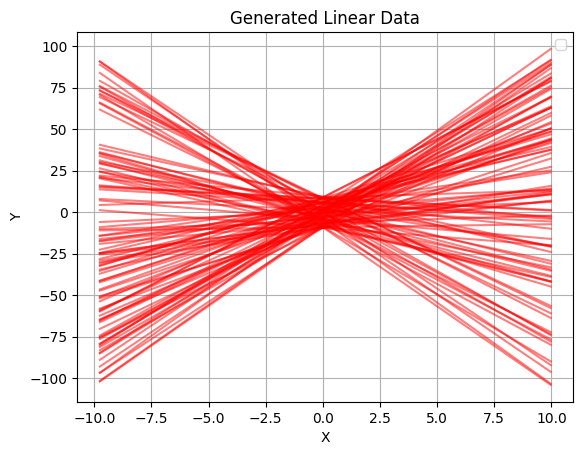

In [10]:
x_data_np = x_data.numpy()
y_data_np = y_data.numpy()

for slope, intercept in zip(slopes, intercepts):
    x_line = np.linspace(np.min(x_data_np), np.max(x_data_np), 100)
    y_line = slope * x_line + intercept
    plt.plot(x_line, y_line, color='red', alpha=0.5)

plt.title('Generated Linear Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
x_data.shape, y_data.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

In [16]:
model = Multiscale1DFitter(function=linear_function, x_data=x_data, input_channels=1, num_params=2)
# model = ConvModel()
# model = LinearModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.MSELoss()
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [19]:
fit(model, optimizer, loss_func, scheduler, x_data, y_data)

RuntimeError: Calculated padded input size per channel: (1). Kernel size: (3). Kernel size can't be greater than actual input size

In [35]:
def evaluate(model, loss_func, x_data, y_data, device='cuda'):
    model.eval()
    x_data = x_data.to(device)
    y_data = y_data.to(device)
    with torch.no_grad():
        #x_data = x_data.unsqueeze(1)
        outputs, _ = model(x_data)#, n=len(x_data))

        loss = loss_func(outputs, y_data)
        print(f'Validation Loss: {val_loss:.4f}')        

In [ ]:
x_case = torch.tensor([[1.0], [2.0], [3.0]], dtype=torch.float32)
with torch.no_grad():
    y_pred = model(x_case)
    print(f'Predictions for input x: {x_case.squeeze().numpy()}')
    print(f'Predicted y: {y_pred.squeeze().numpy()}')

In [31]:
x_val, y_val, _, _ = generate_linear_data()

In [25]:
evaluate(model, loss_func,x_val, y_val)

NameError: name 'evaluate' is not defined

In [ ]:
'''
def generate_data(num_samples):
    x_values = torch.randn(num_samples, 1)
    params = torch.randn(num_samples, 2)
    
    y_values = linear_function(params, x_values)
    y_values += torch.randn_like(y_values) * 0.1
    
    return x_values, y_values
'''

In [ ]:
'''
dataset = generate_data(100)
plt.figure(figsize=(8, 6))
plt.scatter(dataset[0].numpy(), dataset[1].numpy(), color='b', label='Data Points')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.title('Scatter Plot of x_values vs y_values')
plt.legend()
plt.grid(True)
plt.show()
'''

In [ ]:
'''
def fit(model, optimizer_, loss_func, data_train, epochs, batch_size=128, datatype=torch.float32, device='cuda'):
    loss_ = []

    # sets the model to be a specific datatype and on cuda
    model.to(datatype).to(device)

    torch.cuda.empty_cache()

    # instantiate the dataloader
    train_dataloader = DataLoader(data_train, batch_size=batch_size, shuffle=True)

    total_time = 0
    low_loss_count = 0

    # says if the model have already stopped early
    already_stopped = False

    model_updates = 0

    # loops around each epoch
    for epoch in range(epochs):
        train_loss = 0.0
        total_num = 0
        epoch_time = 0

        # sets the model to training mode
        model.train()

        for train_batch in train_dataloader:
            model_updates += 1

            # starts the timer
            start_time = time.time()

            train_batch = train_batch.to(datatype).to(device)

            pred, embedding = model(train_batch)
            pred = pred.to(torch.float32)
            pred = torch.atleast_3d(pred)
            embedding = embedding.to(torch.float32)

            optimizer_.zero_grad()

            loss = loss_func(train_batch, pred)
            loss.backward(create_graph=True)

            train_loss += loss.item() * pred.shape[0]
            total_num += pred.shape[0]

            optimizer_.step()

            try:
                loss_.append(loss.item())
            except:
                loss_.append(loss)

        train_loss /= total_num

        print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, train_loss))
        print("--- %s seconds ---" % (epoch_time))

        # scheduler.step(train_loss)

        # Print the current learning rate (optional)
        current_lr = optimizer_.param_groups[0]['lr']
        print(f"Epoch {epoch+1}, Learning Rate: {current_lr}")
'''

In [ ]:
'''
def fit(model, optimizer, loss_func, x_data, y_data, num_epochs=100, batch_size=32, device='cuda'):
    model.train()  # Set the model to training mode

    # Move data to device
    x_data = x_data.to(device)
    y_data = y_data.to(device)

    # Number of samples
    num_samples = x_data.size(0)

    # Training loop
    for epoch in range(num_epochs):
        epoch_loss = 0.0

        # Mini-batch training
        for i in range(0, num_samples, batch_size):
            # Get mini-batch data
            x_batch = x_data[i:i+batch_size]
            y_batch = y_data[i:i+batch_size]

            # Ensure x_batch has expected shape (batch size, channels, sequence length)
            # Assuming your Multiscale1DFitter expects input with shape (batch size, channels, sequence length)
            x_batch = x_batch.unsqueeze(1)  # Add channel dimension

            # Check if x_batch sequence length is sufficient for the largest kernel size used in hidden_x1
            min_seq_length_required = max(7, 7, 5)  # Maximum kernel sizes used in hidden_x1 layers
            if x_batch.size(2) < min_seq_length_required:
                continue  # Skip mini-batch if sequence length is too short

            # Forward pass
            optimizer.zero_grad()
            outputs, _ = model(x_batch, n=len(x_batch))  # Assuming training=True, outputs contains scaled predictions

            # Compute loss
            loss = loss_func(outputs, y_batch)

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * len(x_batch)

        # Compute average epoch loss
        epoch_loss /= num_samples

        # Print epoch loss
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
        
'''        